In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# plots in LaTeX-style
import tueplots
from tueplots import bundles
plt.rcParams.update(bundles.neurips2022())

In [2]:
# load data
data = pd.read_csv("../data/Food_Production.csv", sep=";")

# Data exploration

In [3]:

data.head()

,Food product,Plant based,Land Use Change,Animal Feed,Farm,Processing,Transport,Packaging,Retail,Total Emissions,...,Freshwater Withdrawals per 100g Protein (liters per 100g Protein),Freshwater Withdrawals per kilogram (liters per kilogram),Greenhouse Gas Emissions per 1000kcal (kgCO2eq per 1000kcal),Greenhouse Gas Emissions per 100g Protein (kgCO2eq per 100g Protein),Land Use per 1000kcal (m2 per 1000kcal),Land Use per Kilogram (m2 per kilogram),Land Use per 100g Protein (m2 per 100g Protein),Scarcity weighted Water Use per Kilogram (liters per kilogram),Scarcity weighted Water Use per 100g protein (liters per 100g protein),Scarcity weighted Water use per 1000kcal (liters per 1000 kilocalories)
0,Wheat & Rye (Bread),1,0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),1,0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),1,0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,1,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,...,371.076923,482.4,0.945482,1.907692,2.897446,7.6,5.846154,18786.2,14450.92308,7162.104461
4,Rice,1,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,...,3166.760563,2248.4,1.207271,6.267606,0.759631,2.8,3.943662,49576.3,69825.77465,13449.891480


In [4]:
data.columns

Index(['Food product', 'Plant based', 'Land Use Change', 'Animal Feed', 'Farm',
       'Processing', 'Transport', 'Packaging', 'Retail', 'Total Emissions',
       'Eutrophying Emissions per 1000kcal (gPO4eq per 1000kcal)',
       'Eutrophying Emissions per Kilogram (gPO4eq per kilogram)',
       'Eutrophying Emissions per 100g protein (gPO4eq per 100 grams protein)',
       'Freshwater Withdrawals per 1000kcal (liters per 1000kcal)',
       'Freshwater Withdrawals per 100g Protein (liters per 100g Protein)',
       'Freshwater Withdrawals per kilogram (liters per kilogram)',
       'Greenhouse Gas Emissions per 1000kcal (kgCO2eq per 1000kcal)',
       'Greenhouse Gas Emissions per 100g Protein (kgCO2eq per 100g Protein)',
       'Land Use per 1000kcal (m2 per 1000kcal)',
       'Land Use per Kilogram (m2 per kilogram)',
       'Land Use per 100g Protein (m2 per 100g Protein)',
       'Scarcity weighted Water Use per Kilogram (liters per kilogram)',
       'Scarcity weighted Water Use p

In [5]:
# Imputation of the missing values via arithmetic mean
data = data.fillna(data.mean(numeric_only=True))

In [6]:
data_plant = data[data["Plant based"] == True]
data_animal = data[data["Plant based"] == False]

# **Example diet comparison**

Let us now compare two samples of an average omnivor diet and an average plant based diet, in order to see the difference in the emissions.

Biggest UK health website suggests 2000kcal for an average woman: [NHS UK](https://www.nhs.uk/live-well/healthy-weight/managing-your-weight/understanding-calories/#:~:text=As%20a%20guide%2C%20an%20average,physical%20activity%2C%20among%20other%20factors).

The division among macronutrients is taken as follows from [healthline](https://www.healthline.com/nutrition/best-macronutrient-ratio):

*   45–65% of the calories from carbs (225g-325g in our case)
*   20–35% of the calories from fats (45g-78g in our case)
*   10–35% of the calories from proteins (50g-175g in our case)

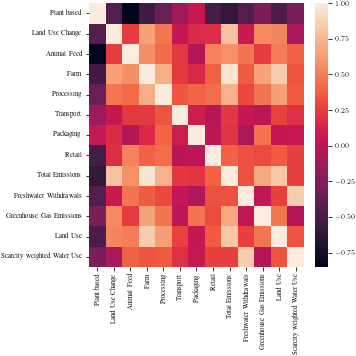

In [7]:
# for nice plots (svg) in LaTeX math mode:
with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=0.5, nrows=1, ncols=1)):
    # Setup code
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (5,5))

    # Plotting code
    columns = ['Food product', 'Plant based', 'Land Use Change', 'Animal Feed', 'Farm',
       'Processing', 'Transport', 'Packaging', 'Retail', 'Total Emissions',
       'Freshwater Withdrawals per kilogram (liters per kilogram)',
       'Greenhouse Gas Emissions per 1000kcal (kgCO2eq per 1000kcal)',
       'Land Use per Kilogram (m2 per kilogram)',
       'Scarcity weighted Water Use per Kilogram (liters per kilogram)']
    labels = ['Food product', 'Plant based', 'Land Use Change', 'Animal Feed', 'Farm',
       'Processing', 'Transport', 'Packaging', 'Retail', 'Total Emissions',
       'Freshwater Withdrawals',
       'Greenhouse Gas Emissions',
       'Land Use',
       'Scarcity weighted Water Use']
    data_corr = data[columns]
    #data_corr = data_corr.set_axis(labels, axis=1).corr(numeric_only=True)
    data_corr = data_corr.set_axis(labels, axis=1).corr()
    corr_plot = sns.heatmap(data_corr, ax=axs)

    # Save plot
    fig.savefig(
    "figures/corrplot.pdf",
    bbox_inches="tight",
    pad_inches=0.01,
    )

In [8]:
# List of tuples (food, grams) of the diet
diet = [("Wheat & Rye (Bread)", 400), 
        ("Pig Meat", 200),
        ("Bananas", 300),
        ("Cheese", 150)]

In [14]:
# Function to sum the emission of every food in the diet, with the relative quantity
def calculate_diet_emissions(diet, data):
  tot_emissions = 0
  for item in diet:
    food_emissions = data[data["Food product"] == item[0]]["Total Emissions"]
    item_emissions = food_emissions * item[1] / 1000
    tot_emissions += item_emissions.values[0]
  return tot_emissions

In [15]:
emissions_omnivor = calculate_diet_emissions(diet, data)
print("The example omnivor diet produces " + str(emissions_omnivor) + "kg of CO2 per day on average.")

The example omnivor diet produces 5.42kg of CO2 per day on average.


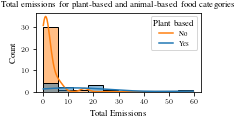

In [17]:
# for nice plots (svg) in LaTeX math mode:
with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=0.5, nrows=1, ncols=1)):
    # Setup code
    fig, axs = plt.subplots(nrows=1, ncols=1)

    # Plotting code
    plant_hist = sns.histplot(x="Total Emissions", bins=10, legend=True, 
                              ax=axs, kde=True, hue="Plant based", data=data)
    plt.legend(title='Plant based', loc='upper right', labels=['No', 'Yes'])
    plt.title("Total emissions for plant-based and animal-based food categories")
    # Save plot
    # fig.savefig(
    # "figures/testplot.pdf",
    # bbox_inches="tight",
    # pad_inches=0.01,
    # )

Observation:
- plant based emissions look chi-squared distributed

Problem:
-  Most tests assume gaussian distributed data.
So, let's transform data by applying  log and check out the distribution

### data Transformation:   log()

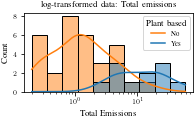

In [16]:
# for nice plots (svg) in LaTeX math mode:
with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=0.5, nrows=1, ncols=1)):
    # Setup code
    fig, axs = plt.subplots(nrows=1, ncols=1)

    # Plotting code
    plant_hist = sns.histplot(x="Total Emissions", bins=10, legend=True, 
                              ax=axs, kde=True, log_scale=True, data=data, hue="Plant based")
    plt.legend(title='Plant based', loc='upper right', labels=['No', 'Yes'])
    plt.title("log-transformed data: Total emissions")
    # Save plot
    fig.savefig(
    "figures/logplot.pdf",
    bbox_inches="tight",
    pad_inches=0.01,
    )

### TODO:
- Test (and why this test)
    - depict reasoning as to why log scale and respective t-test plotting one w/o log-scale --> similar to chi-squared distribution, plus plot in log-scale, which shows a distribution mor similar to a normal distribution. 
    - experiment with kde, maybe no histogram but only kde and mean

### TODO:
- Add Legend:
    -   put animal and plant based column in one df so that plotting with legend will be possible 
- Test (and why this test)
    - depict reasoning as to why log scale and respective t-test plotting one w/o log-scale --> similar to chi-squared distribution, plus plot in log-scale, which shows a distribution mor similar to a normal distribution. 
    - experiment with kde, maybe no histogram but only kde and mean

# Data Analysis

## T-Tests

H_0:

H_1:
